### Fine Tuning Best Model (XGBoost) and Evaluation
1. Select Best Model and Hyperparameter tuning
    1. Grid Search CV
2. Final Training
    1. Best hypertuned model
    1. Analyze the results - evaluation metrics and SHAP

In [1]:
# importing requried libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap

# custom modules
from cardiovascular_disease_prediction.dataset import load_dataset
from cardiovascular_disease_prediction.feature_transformer import cardio_data_pipeline
from cardiovascular_disease_prediction.evaluate import evaluate_model

In [2]:
TEST_SIZE=0.2
RANDOM_SEED=42

### ELT Process

In [3]:
# load data
df = load_dataset()
X, y = df.drop(labels='cardio', axis=1), df['cardio']

# transform pipeline
transformation_pipe = cardio_data_pipeline()
X_ = transformation_pipe.fit_transform(X)
print("Transformed Data Shape: ", X_.shape)

Attempting to load dataset from: C:\Users\visha\OneDrive\Documents\GitHub\Data-Science-Stuff\predicting_cardio_disease\data\raw\cardio_train.csv
Dataset loaded successfully from C:\Users\visha\OneDrive\Documents\GitHub\Data-Science-Stuff\predicting_cardio_disease\data\raw\cardio_train.csv
Transformed Data Shape:  (70000, 26)


In [4]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)
print("Training Set:", X_train.shape)
print("Testing Set:", X_test.shape)

Training Set: (56000, 26)
Testing Set: (14000, 26)


### HyperParameter Tuning

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

param_grid = {
    'max_depth': [3, 5, 7, 9],          # Depth of the trees
    'n_estimators': [50, 100, 200],  # Number of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.8, 0.9, 1.0],         # Fraction of samples used for training
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2, 0.5],          # Minimum loss reduction for a split
    'min_child_weight': [1, 3, 5],    # Minimum sum of instance weight for a child
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Use F1-score as the evaluation metric
    cv=5,          # 5-fold cross-validation
    verbose=1,     # Print progress
    n_jobs=-1      # Use all available cores
)

# Fit the Grid Search
grid_search.fit(X_train, y_train)

# Get the Best Parameters and Model
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

## Final Training
### 1. Best Tuned Model

In [35]:
best_params = {
    'max_depth':9,
    'learning_rate':0.01,
    'n_estimators':1200,
    'subsample':0.85,
    'colsample_bytree':0.85,
    'gamma':0.5,
    'reg_alpha':1,
    'reg_lambda':1,
    'scale_pos_weight':1,
    'early_stopping_rounds':100,
    'tree_method':'hist',
    'eval_metric':'logloss',
    'random_state':42
}

xgb_model = XGBClassifier(**best_params)
xgb_model = xgb_model.fit(X_train, y_train,
                          eval_set=[(X_test, y_test)],
                          verbose=0)
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, device=None, early_stopping_rounds=100,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.5,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1200, n_jobs=None,
              num_parallel_tree=None, ...)

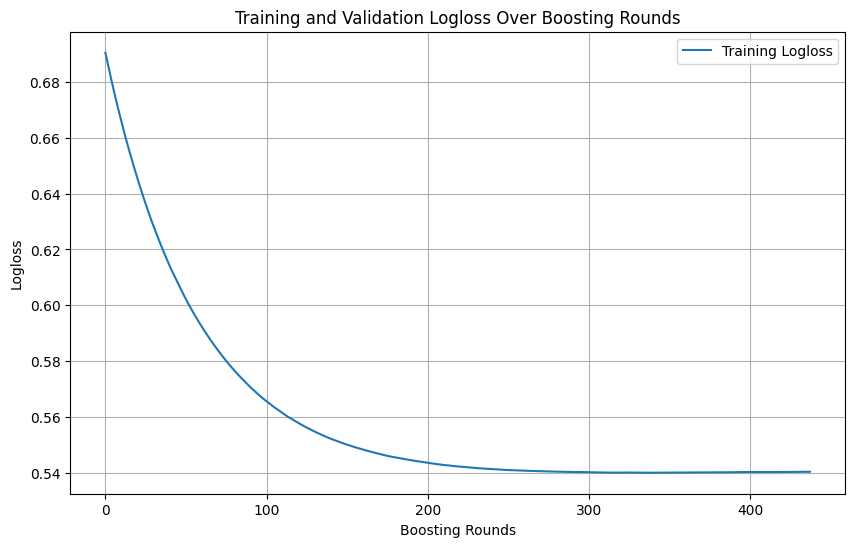

In [36]:
evals_result = xgb_model.evals_result()

# Plot logloss for training and validation sets
epochs = range(len(evals_result['validation_0']['logloss']))  # Get the number of boosting rounds

plt.figure(figsize=(10, 6))
plt.plot(epochs, evals_result['validation_0']['logloss'], label='Training Logloss')

# Add labels, title, and legend
plt.xlabel('Boosting Rounds')
plt.ylabel('Logloss')
plt.title('Training and Validation Logloss Over Boosting Rounds')
plt.legend()
plt.grid()
plt.show()

### Evaluate the Model

In [7]:
## evaluate
metrics = evaluate_model(xgb_model, X_test, y_test)

Evaluation Metrics:

Accuracy: 0.7389
Precision: 0.7595
Recall: 0.7007
F1 Score: 0.7289
ROC AUC Score: 0.8020

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      6988
           1       0.76      0.70      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.74     14000
weighted avg       0.74      0.74      0.74     14000



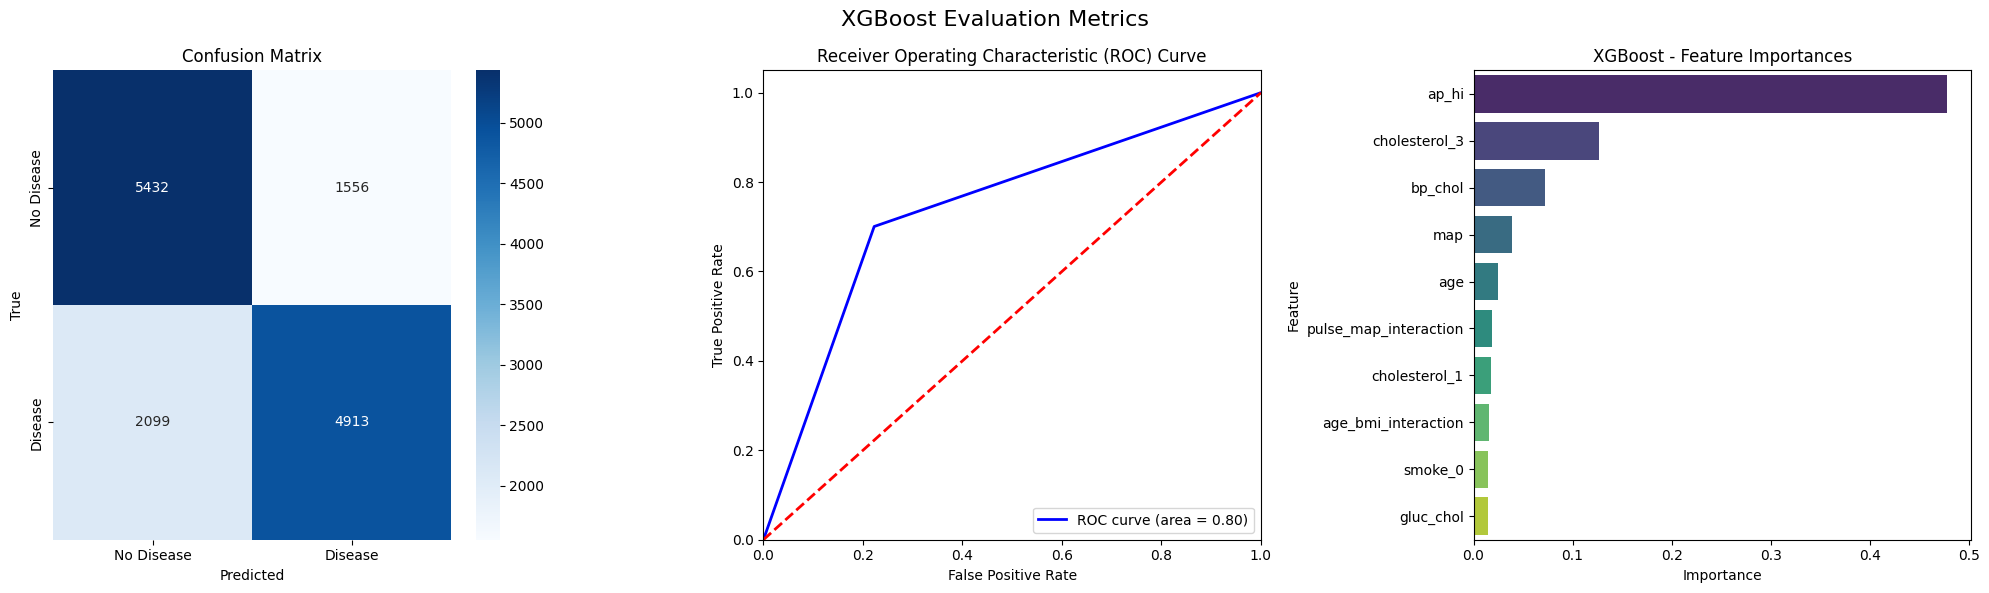

In [8]:
## 
from cardiovascular_disease_prediction.plots import plot_evaluation_metrics
plot_evaluation_metrics(
    model=xgb_model,
    X_test=X_test,
    y_true=y_test,
    model_name='XGBoost')

### SHAP Explainibility

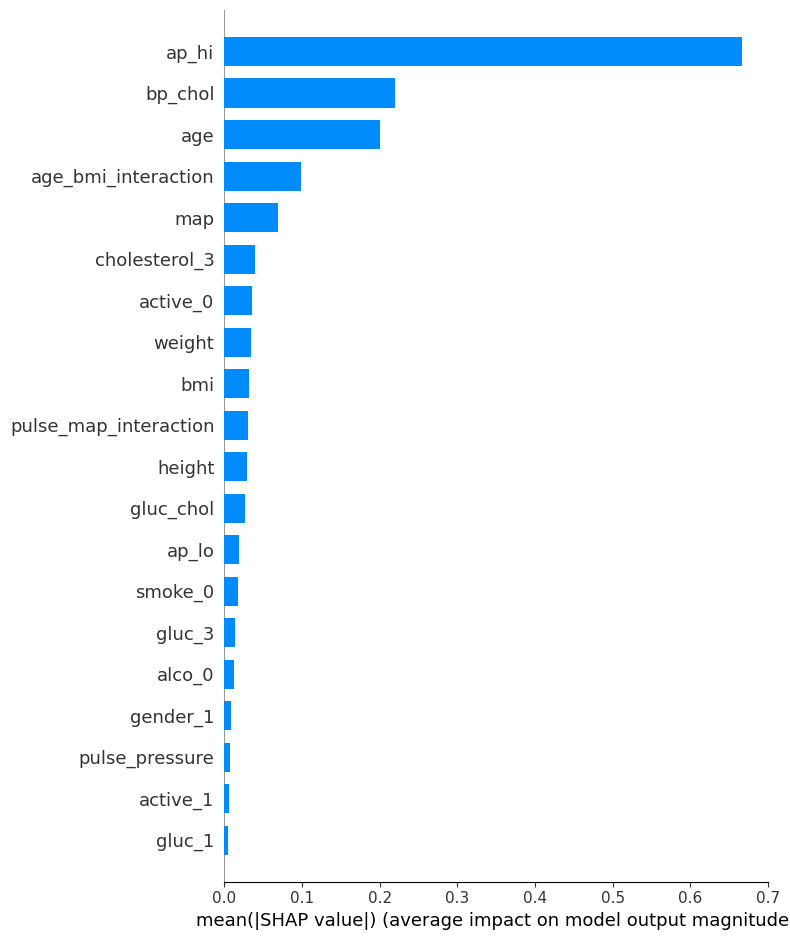

In [9]:
## Shap
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

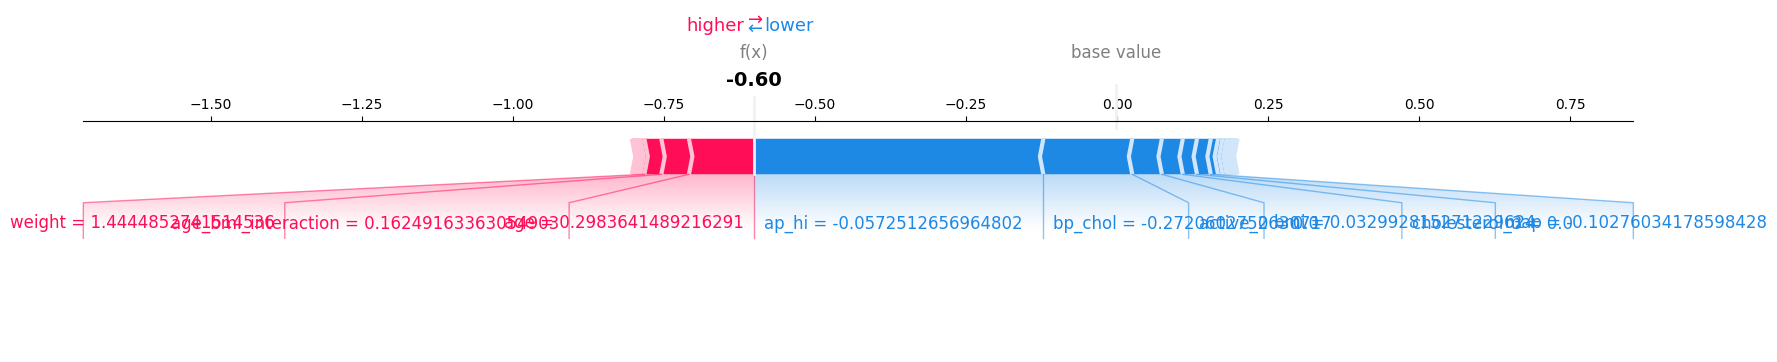

In [11]:
idx = 42
shap.force_plot(explainer.expected_value, shap_values[idx, :], X_test.iloc[idx, :], matplotlib=True)

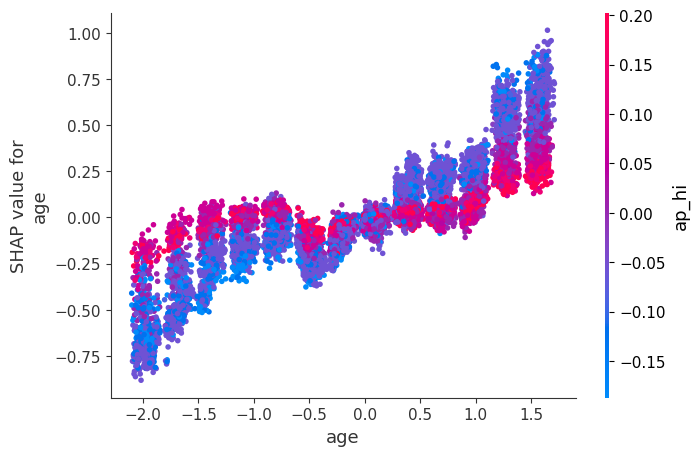

In [21]:
shap.dependence_plot("age", shap_values, X_test)

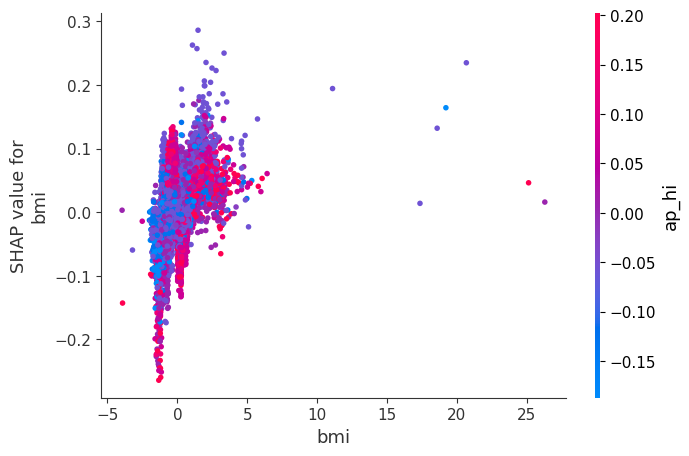

In [18]:
shap.dependence_plot("bmi", shap_values, X_test)

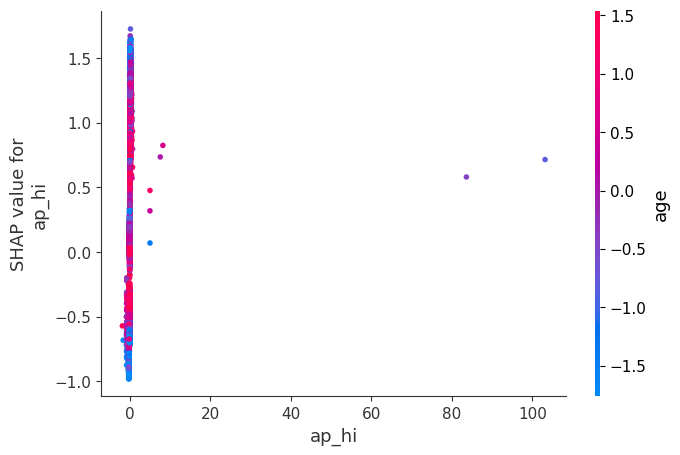

In [19]:
shap.dependence_plot("ap_hi", shap_values, X_test)

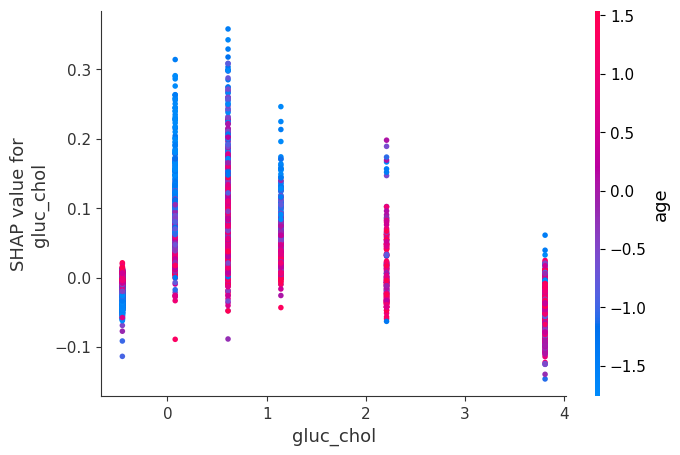

In [20]:
shap.dependence_plot("gluc_chol", shap_values, X_test)

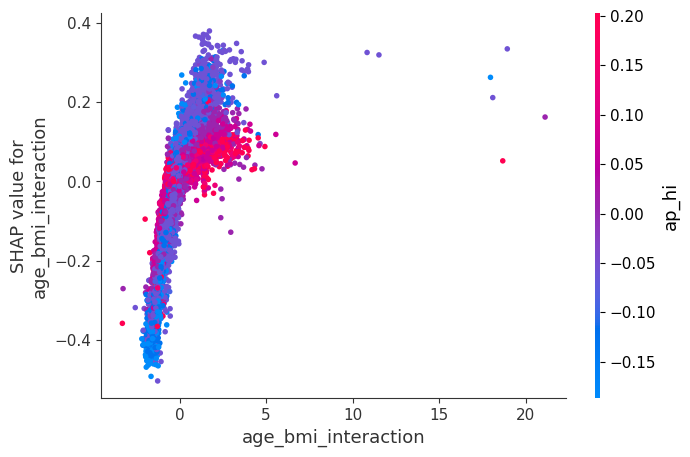

In [22]:
shap.dependence_plot("age_bmi_interaction", shap_values, X_test)

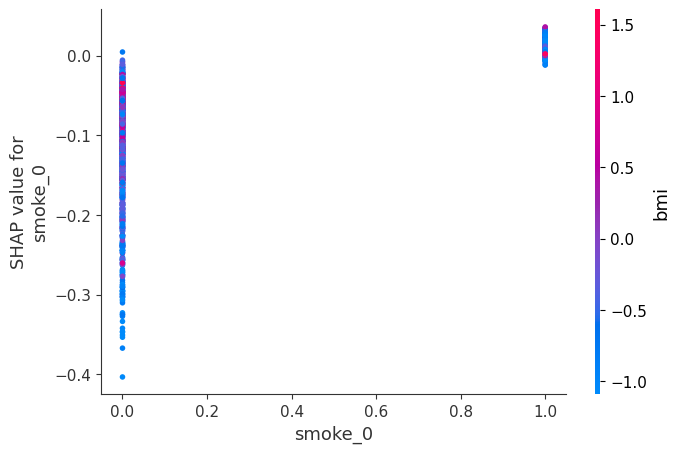

In [28]:
shap.dependence_plot("smoke_0", shap_values, X_test)

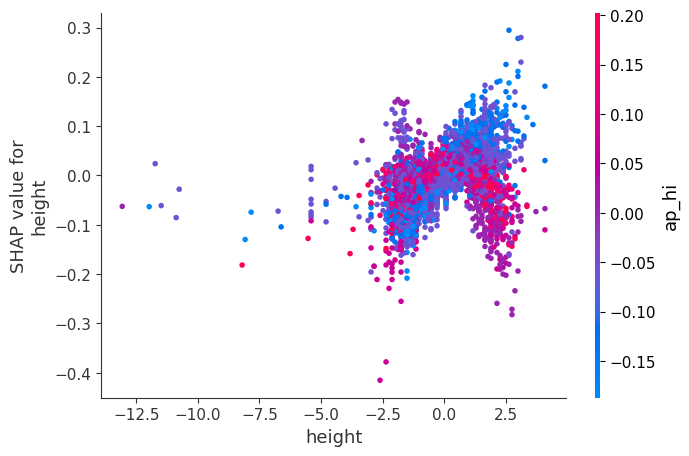

In [29]:
shap.dependence_plot("height", shap_values, X_test)

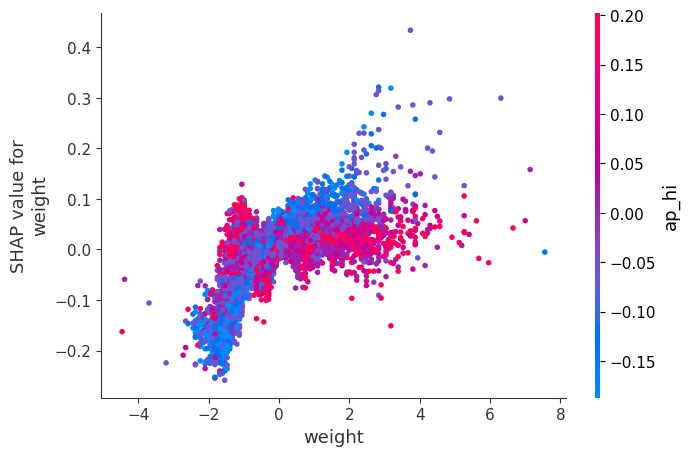

In [30]:
shap.dependence_plot("weight", shap_values, X_test)

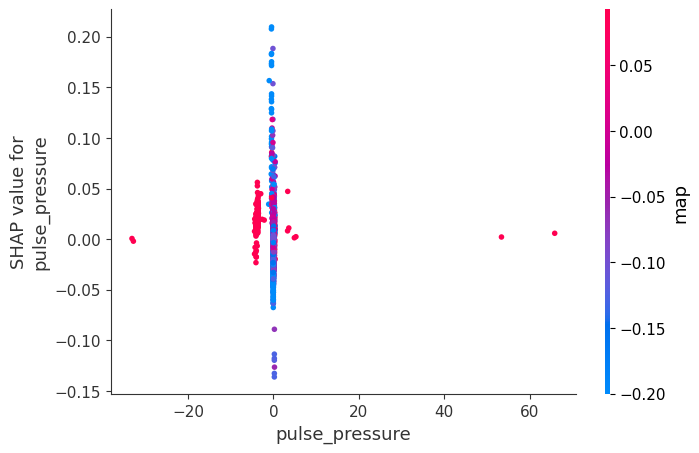

In [37]:
shap.dependence_plot("pulse_pressure", shap_values, X_test)